In [10]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from keras.preprocessing import image   
from keras.callbacks import ModelCheckpoint  
from tqdm import tqdm
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt           

%matplotlib inline          

def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Human faces detector

In [11]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


Number of faces detected: 1


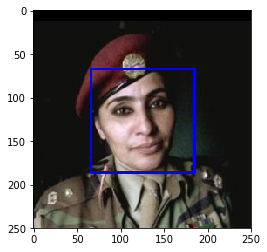

In [12]:
# Human face detector using pre-trained haarcascades


face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')
img = cv2.imread(human_files[3])
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray)

print('Number of faces detected:', len(faces))

for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [13]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

print('Human faces in human_files_short: {}/{}'.format(sum(map(face_detector, human_files_short)), len(human_files_short)))
print('Human faces in dog_files_short: {}/{}'.format(sum(map(face_detector, dog_files_short)), len(dog_files_short)))  

### Dog detector

In [14]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
ResNet50_model = ResNet50(weights='imagenet')

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [18]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [26]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

print('Dogs in human_files_short: {}/{}'.format(sum(map(dog_detector, human_files_short)), len(human_files_short)))
print('Dogs in dog_files_short: {}/{}'.format(sum(map(dog_detector, dog_files_short)), len(dog_files_short)))   


Dog faces in human_files_short: 0/100
Dog faces in dog_files_short: 100/100


## Dog breed classifier using transfer learning

In [70]:
# Obtain bottleneck features from another pre-trained ResNet50.

bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [110]:

myResnet50_model = Sequential()
myResnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
myResnet50_model.add(Dense(512, activation='relu'))
myResnet50_model.add(Dropout(0.2))
myResnet50_model.add(Dense(133, activation='softmax'))
myResnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_24  (None, 2048)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_17 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 133)               68229     
Total params: 1,117,317
Trainable params: 1,117,317
Non-trainable params: 0
_________________________________________________________________


In [111]:
myResnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [112]:
# Train 
epochs = 10

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet51.hdf5', 
                               verbose=1, save_best_only=True)

myResnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 3s 500us/step - loss: 1.9536 - acc: 0.5219 - val_loss: 0.8888 - val_acc: 0.7269
Epoch 2/10
6680/6680 [==============================] - 2s 341us/step - loss: 0.7475 - acc: 0.7717 - val_loss: 0.8211 - val_acc: 0.7521
Epoch 3/10
6680/6680 [==============================] - 2s 338us/step - loss: 0.4941 - acc: 0.8428 - val_loss: 0.7717 - val_acc: 0.7844
Epoch 4/10
6680/6680 [==============================] - 2s 334us/step - loss: 0.3842 - acc: 0.8754 - val_loss: 0.8866 - val_acc: 0.7749
Epoch 5/10
6680/6680 [==============================] - 2s 333us/step - loss: 0.3040 - acc: 0.9034 - val_loss: 0.8599 - val_acc: 0.7880
Epoch 6/10
6680/6680 [==============================] - 2s 337us/step - loss: 0.2394 - acc: 0.9243 - val_loss: 0.9714 - val_acc: 0.7904
Epoch 7/10
6680/6680 [==============================] - 2s 332us/step - loss: 0.1897 - acc: 0.9409 - val_loss: 1.0183 - val_acc: 0.7988
E

In [113]:
# Load the model weights with the best validation loss.
myResnet50_model.load_weights('saved_models/weights.best.Resnet51.hdf5')

In [114]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set


Resnet50_predictions = [np.argmax(myResnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.9474%


In [194]:
def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = myResnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def out_msg(path_to_img, dog=True, breed=None, err=False):
    if breed and not err:
        breed = breed.split('.')[-1]
        if dog:
            plt.title("I know! It is a...  {}!".format(breed))
        else:
            plt.title("Hi human! You look like a... {}!".format(breed))        
    else:    
        plt.title("Sorry, i don't sure what is it, try another image please.")
    
    img = cv2.imread(path_to_img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

# External API
        
def dog_breed_classifier(path_to_img):
    if dog_detector(path_to_img):
        dog = True
    elif face_detector(path_to_img):
        dog = False
    else:
        out_msg(path_to_img, err=True)
        return 
    breed = Resnet50_predict_breed(path_to_img)
    out_msg(path_to_img, dog=dog, breed=breed, err=False)
    return 
    

---
## Testing:

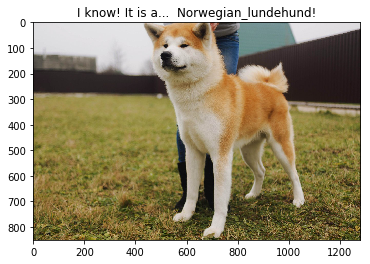

In [195]:
images = glob('./usertest/*')

dog_breed_classifier(images[0])

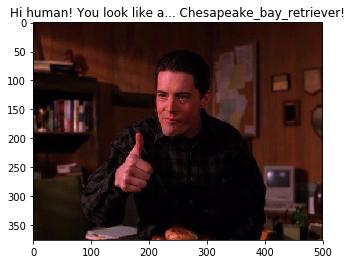

In [196]:
dog_breed_classifier(images[1])

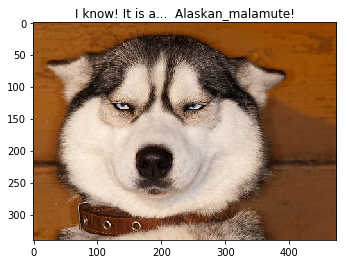

In [197]:
dog_breed_classifier(images[2])

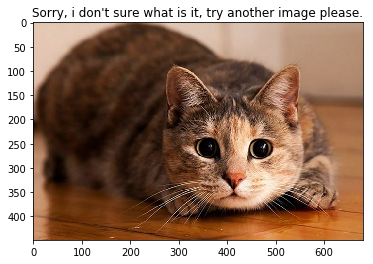

In [198]:
dog_breed_classifier(images[3])

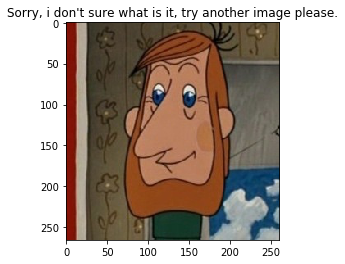

In [199]:
dog_breed_classifier(images[4])

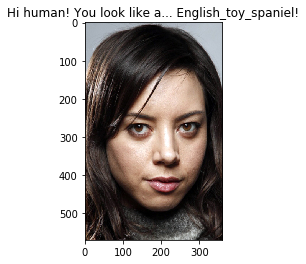

In [200]:
dog_breed_classifier(images[5])

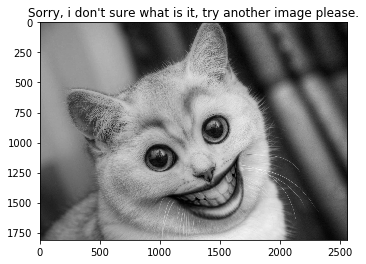

In [201]:
dog_breed_classifier(images[6])